In [79]:
import os
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import logging
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load environment variables
load_dotenv()

True

In [80]:
output_file = os.getenv('OUTPUT_FILE')
file_path = output_file
data = pd.read_csv(file_path)

# Step 1: Rename columns to provide meaningful names
# Manually assign new column names based on their observed contents
columns = [
    "Group",
    "Age",
    "MoCA",
    "UPDRS_III",
    "Hor_Anti_Latency",
    "Hor_Anti_Error",
    "Ver_Anti_Latency",
    "Ver_Anti_Error",
    "Hor_Pro_Right_Latency",
    "Hor_Pro_Right_Speed",
    "Hor_Pro_Right_MaxSpeed",
    "Hor_Pro_Right_Gain",
    "Hor_Pro_Left_Latency",
    "Hor_Pro_Left_Speed",
    "Hor_Pro_Left_MaxSpeed",
    "Hor_Pro_Left_Gain",
    "Ver_Pro_Up_Latency",
    "Ver_Pro_Up_Speed",
    "Ver_Pro_Up_MaxSpeed",
    "Ver_Pro_Up_Gain",
    "Ver_Pro_Down_Latency",
    "Ver_Pro_Down_Speed",
    "Ver_Pro_Down_MaxSpeed",
    "Ver_Pro_Down_Gain",
]

# Assign cleaned column names, dropping unnecessary unnamed columns
data.columns = columns[:data.shape[1]]

# Step 2: Drop unnecessary rows that don't contain data
# Remove rows that are placeholders or headers
data_cleaned = data.dropna(subset=["Age"]).copy()

# Step 3: Convert numeric columns to proper data types
numeric_columns = data_cleaned.columns[1:]  # All columns except 'Group'
data_cleaned[numeric_columns] = data_cleaned[numeric_columns].apply(pd.to_numeric, errors="coerce")

# Step 4: Reset index for cleaner data
data_cleaned.reset_index(drop=True, inplace=True)

data_cleaned = data_cleaned.drop(index=[0, 1])

# Checking the full shape of the cleaned data to confirm the number of rows and if there are unexpected drops
data_cleaned.shape


(98, 24)

In [81]:
data_cleaned.head()

,Group,Age,MoCA,UPDRS_III,Hor_Anti_Latency,Hor_Anti_Error,Ver_Anti_Latency,Ver_Anti_Error,Hor_Pro_Right_Latency,Hor_Pro_Right_Speed,...,Hor_Pro_Left_MaxSpeed,Hor_Pro_Left_Gain,Ver_Pro_Up_Latency,Ver_Pro_Up_Speed,Ver_Pro_Up_MaxSpeed,Ver_Pro_Up_Gain,Ver_Pro_Down_Latency,Ver_Pro_Down_Speed,Ver_Pro_Down_MaxSpeed,Ver_Pro_Down_Gain
2,PD1,58.49,24.0,40.0,329.781250,3.125000,392.000000,33.333333,269.900000,284.034000,...,454.192500,0.892500,290.000000,139.637500,506.936000,1.006875,277.062500,56.678125,197.205625,1.010000
3,PD2,72.79,30.0,18.0,264.290323,64.516129,249.814815,70.370370,185.416667,235.810833,...,359.972727,0.840909,189.615385,200.039333,482.352857,1.022000,249.733333,179.216667,403.485333,1.130667
4,PD3,71.18,20.0,52.0,218.900000,51.612903,278.344828,48.275862,167.000000,205.985000,...,351.744000,0.679000,198.857143,85.872857,221.724286,0.785000,204.000000,103.774667,264.893333,0.698000
5,PD4,60.80,28.0,24.0,295.222222,55.555556,310.571429,71.428571,209.900000,242.385000,...,511.176250,0.831250,272.461538,102.453077,260.980000,0.733846,237.785714,70.583571,206.768571,0.971429
6,PD5,59.61,26.0,22.0,157.161290,96.774194,183.700000,93.548387,157.700000,232.112500,...,417.408333,0.863333,164.500000,194.479000,435.523750,0.796000,172.000000,227.960000,478.098000,0.996667


In [82]:
# Separate the groups
groups = data_cleaned['Group'].unique()

# Filter data into respective groups
hc_data = data_cleaned[data_cleaned['Group'].str.contains("HC", na=False)]
pd_data = data_cleaned[data_cleaned['Group'].str.contains("PD", na=False)]
rbd_data = data_cleaned[data_cleaned['Group'].str.contains("RBD", na=False)]


In [83]:
import numpy as np

def plot_generalized_with_pdf(hc_data, pd_data, rbd_data, data_cleaned, scatter_x, scatter_y, scatter_title, scatter_xlabel, scatter_ylabel, hist_col, hist_title, hist_xlabel, hist_ylabel):
    """
    Generalized plotting function for scatterplots and histograms with smooth PDF curves that start and end at zero.

    Parameters:
    - hc_data, pd_data, rbd_data: DataFrames for HC, PD, and RBD groups.
    - data_cleaned: Full cleaned dataset (for histograms).
    - scatter_x, scatter_y: Columns for x and y axes in scatterplot.
    - scatter_title, scatter_xlabel, scatter_ylabel: Titles and labels for scatterplot.
    - hist_col: Column for histogram.
    - hist_title, hist_xlabel, hist_ylabel: Titles and labels for histogram.
    """
    # Scatterplot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=hc_data[scatter_x], y=hc_data[scatter_y], label='HC (Healthy Control)', marker='o')
    sns.scatterplot(x=pd_data[scatter_x], y=pd_data[scatter_y], label='PD (Parkinson)', marker='s')
    sns.scatterplot(x=rbd_data[scatter_x], y=rbd_data[scatter_y], label='RBD (REM Disorder)', marker='^')
    plt.title(scatter_title)
    plt.xlabel(scatter_xlabel)
    plt.ylabel(scatter_ylabel)
    plt.legend()
    plt.show()

    # Histogram with PDF for the full dataset
    plt.figure(figsize=(12, 4))
    sns.histplot(data_cleaned[hist_col], bins=20, kde=False, stat='density', color='gray', alpha=0.5)
    
    # Smooth PDF curve starting and ending at zero
    kde = sns.kdeplot(data_cleaned[hist_col], fill=False, bw_adjust=1.5, color='blue')
    kde_lines = kde.get_lines()[0].get_data()
    x, y = kde_lines
    x = np.insert(x, 0, x[0])  # Add left endpoint
    y = np.insert(y, 0, 0)     # Set PDF to zero at left endpoint
    x = np.append(x, x[-1])    # Add right endpoint
    y = np.append(y, 0)        # Set PDF to zero at right endpoint
    plt.fill_between(x, y, color='blue', alpha=0.3)
    
    plt.title(hist_title)
    plt.xlabel(hist_xlabel)
    plt.ylabel(hist_ylabel)
    plt.show()

    # Histogram for groups with smooth PDFs
    plt.figure(figsize=(12, 4))
    for data, label, color in zip([hc_data, pd_data, rbd_data], 
                                  ['HC (Healthy Control)', 'PD (Parkinson)', 'RBD (REM Disorder)'], 
                                  ['blue', 'orange', 'green']):
        sns.histplot(data[hist_col], bins=20, kde=False, stat='density', color=color, alpha=0.5, label=label)
        kde = sns.kdeplot(data[hist_col], fill=False, bw_adjust=1.5, color=color)
        kde_lines = kde.get_lines()[0].get_data()
        x, y = kde_lines
        x = np.insert(x, 0, x[0])
        y = np.insert(y, 0, 0)
        x = np.append(x, x[-1])
        y = np.append(y, 0)
        plt.fill_between(x, y, color=color, alpha=0.3)
    
    plt.title(f'{hist_title} podle skupin')
    plt.xlabel(hist_xlabel)
    plt.ylabel(hist_ylabel)
    plt.legend(title='Skupina')
    plt.show()


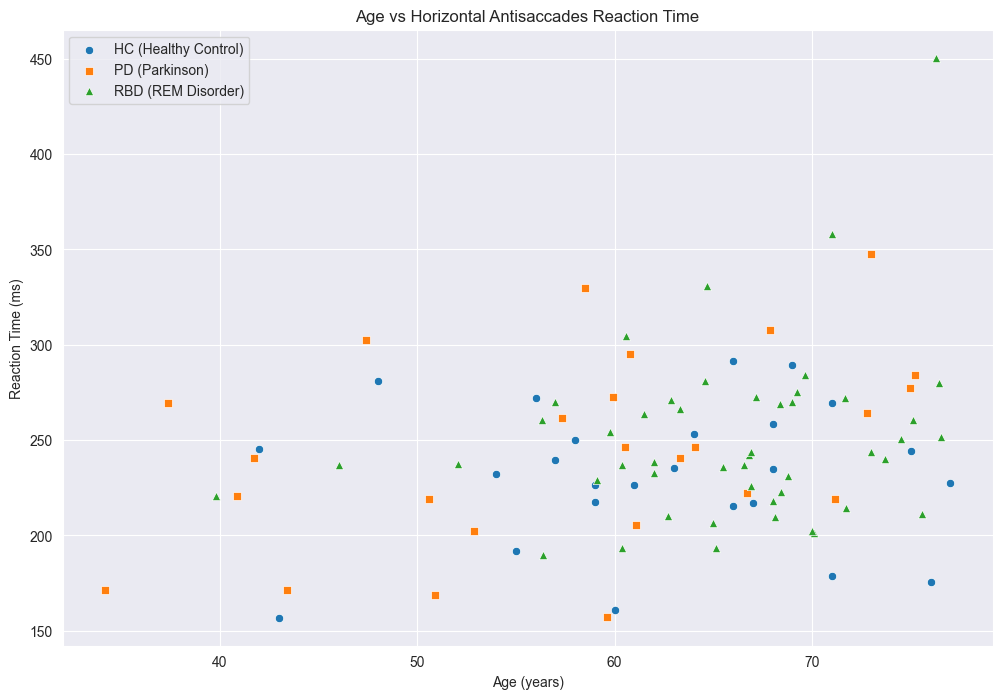

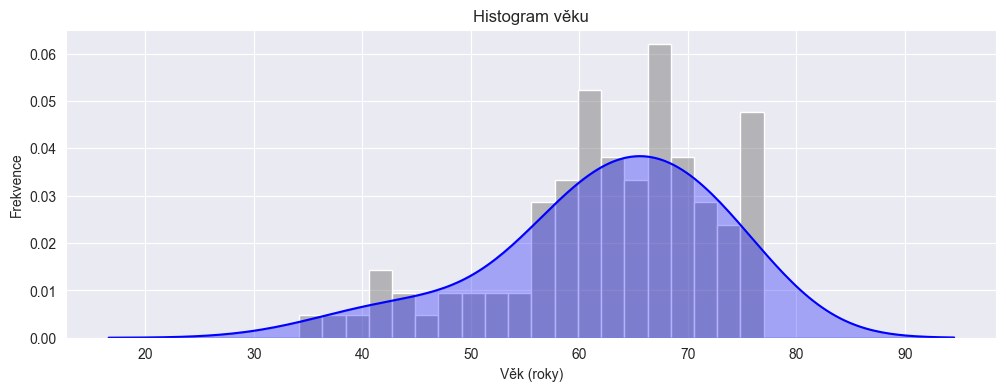

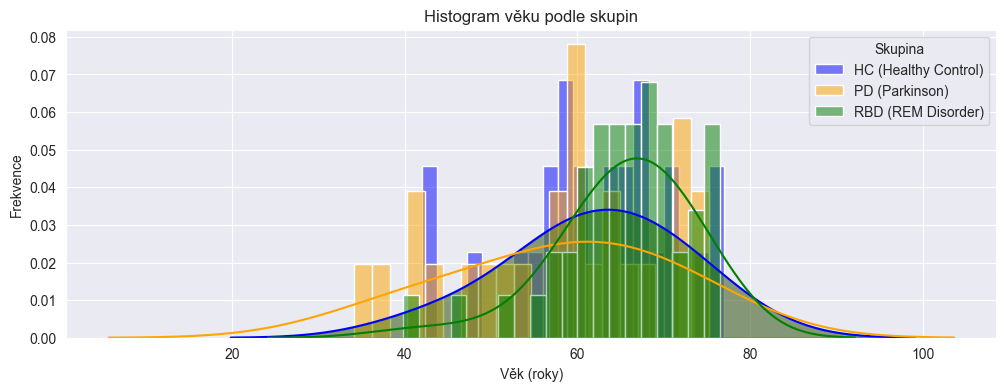

In [84]:
plot_generalized_with_pdf(
    hc_data, pd_data, rbd_data, data_cleaned,
    scatter_x='Age', scatter_y='Hor_Anti_Latency',
    scatter_title='Age vs Horizontal Antisaccades Reaction Time',
    scatter_xlabel='Age (years)', scatter_ylabel='Reaction Time (ms)',
    hist_col='Age',
    hist_title='Histogram věku', hist_xlabel='Věk (roky)', hist_ylabel='Frekvence'
)


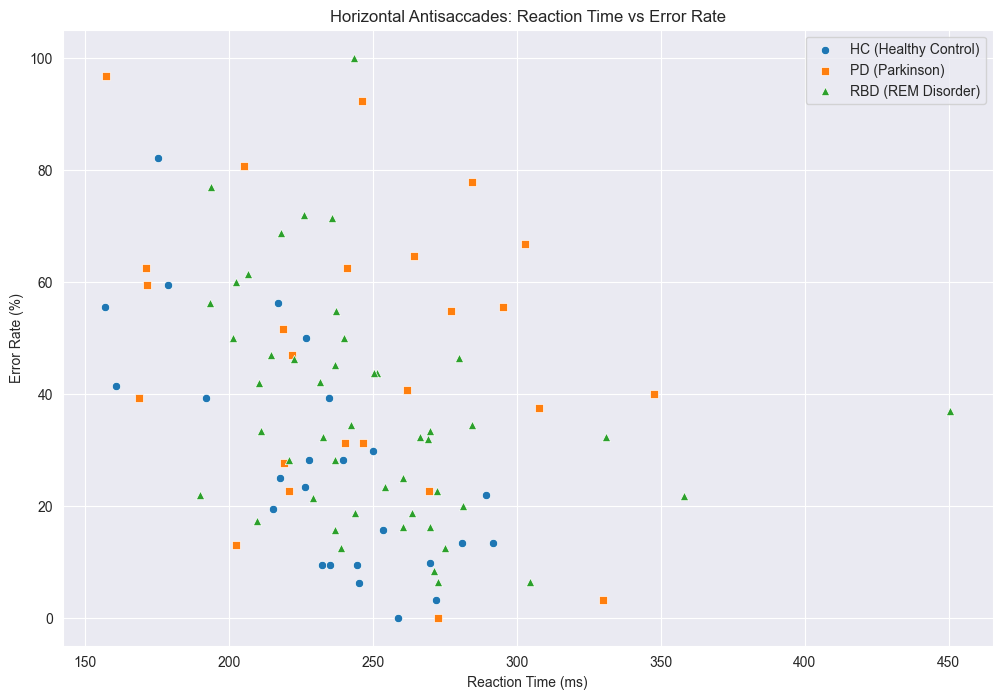

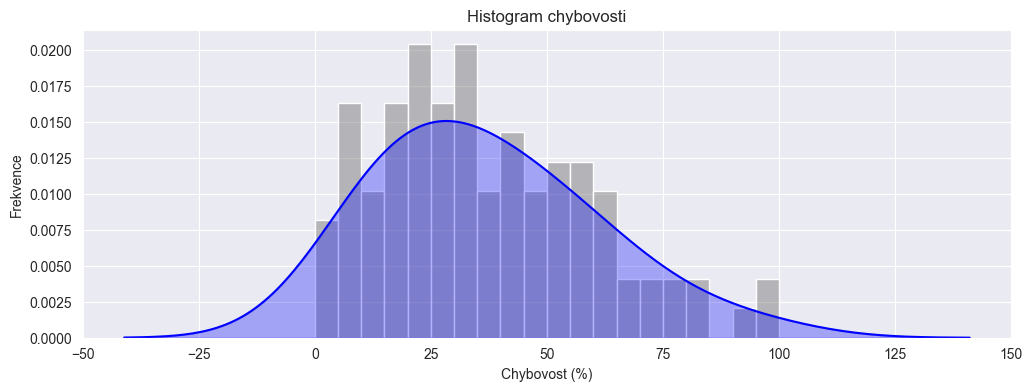

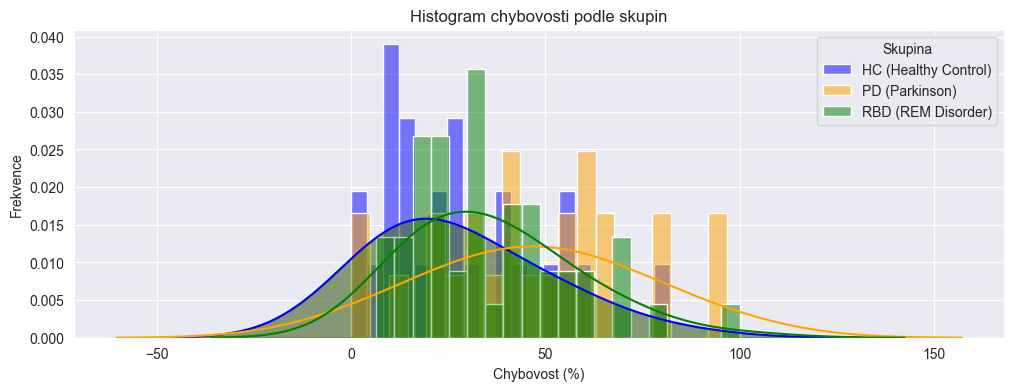

In [85]:
plot_generalized_with_pdf(
    hc_data, pd_data, rbd_data, data_cleaned,
    scatter_x='Hor_Anti_Latency', scatter_y='Hor_Anti_Error',
    scatter_title='Horizontal Antisaccades: Reaction Time vs Error Rate',
    scatter_xlabel='Reaction Time (ms)', scatter_ylabel='Error Rate (%)',
    hist_col='Hor_Anti_Error',
    hist_title='Histogram chybovosti', hist_xlabel='Chybovost (%)', hist_ylabel='Frekvence'
)


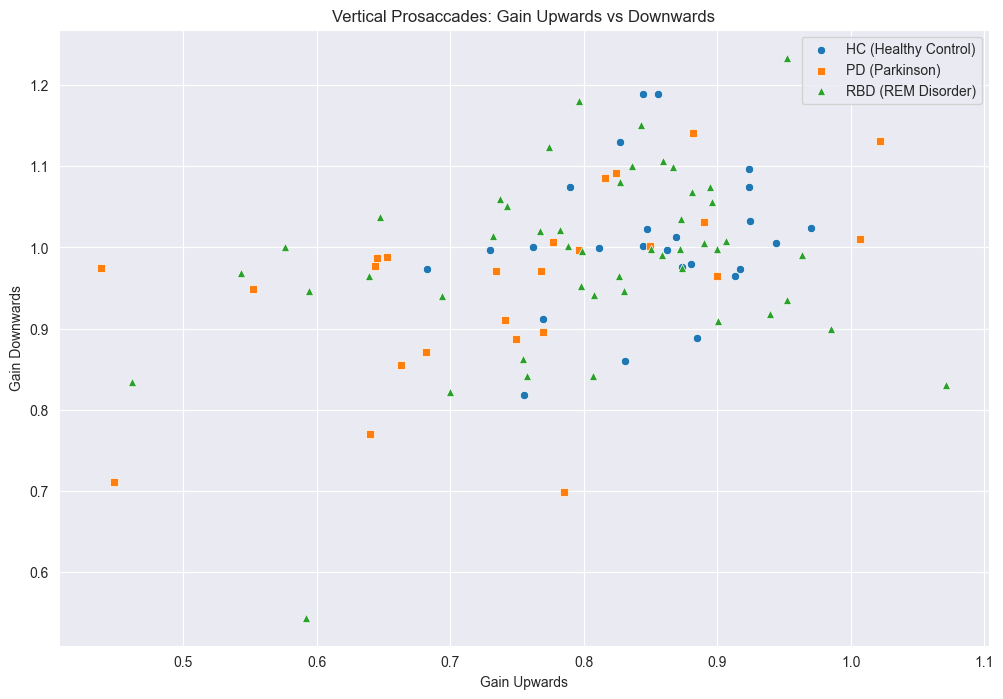

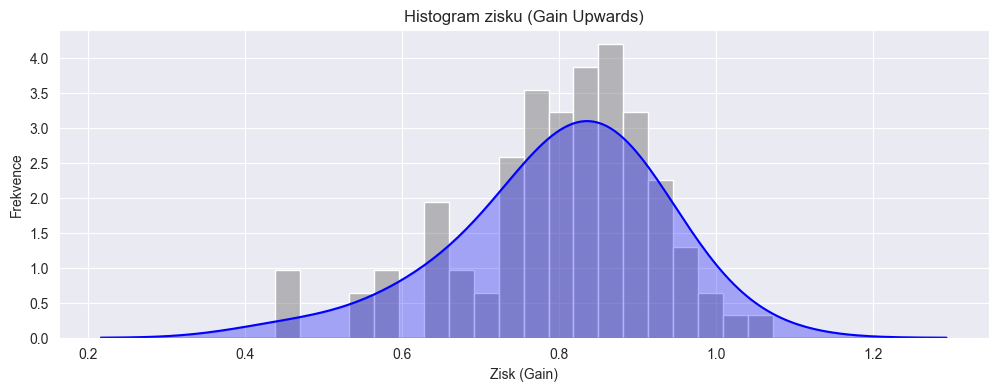

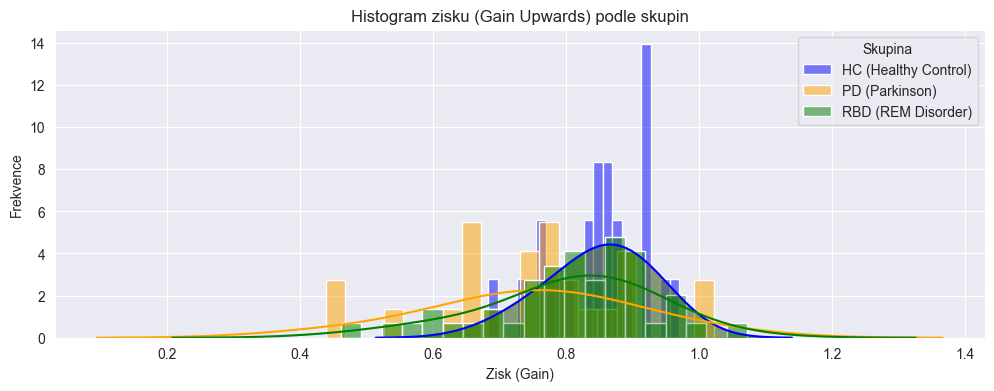

In [86]:
plot_generalized_with_pdf(
    hc_data, pd_data, rbd_data, data_cleaned,
    scatter_x='Ver_Pro_Up_Gain', scatter_y='Ver_Pro_Down_Gain',
    scatter_title='Vertical Prosaccades: Gain Upwards vs Downwards',
    scatter_xlabel='Gain Upwards', scatter_ylabel='Gain Downwards',
    hist_col='Ver_Pro_Up_Gain',
    hist_title='Histogram zisku (Gain Upwards)',
    hist_xlabel='Zisk (Gain)', hist_ylabel='Frekvence'
)



## 3 hypo

In [87]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Zkontrolujte unikátní hodnoty v každé skupině
print(data_cleaned.groupby('Group')['Hor_Anti_Latency'].unique())

Group
HC1                  [227.66]
HC10                [291.665]
HC11                [253.345]
HC12                [235.125]
HC13                [226.635]
                 ...         
RBD85    [330.93333333333334]
RBD87    [269.80645161290323]
RBD90              [214.4375]
RBD91     [263.5483870967742]
RBD96    [220.67741935483872]
Name: Hor_Anti_Latency, Length: 98, dtype: object


In [88]:
# Zjistěte počet pozorování v každé skupině
print(data_cleaned['Group'].value_counts())

Group
PD1      1
HC10     1
RBD25    1
RBD90    1
RBD3     1
        ..
RBD41    1
RBD20    1
RBD32    1
RBD17    1
HC13     1
Name: count, Length: 98, dtype: int64


In [89]:
# Zkontrolujte datové typy
print(data_cleaned.dtypes)

Group                      object
Age                       float64
MoCA                      float64
UPDRS_III                 float64
Hor_Anti_Latency          float64
Hor_Anti_Error            float64
Ver_Anti_Latency          float64
Ver_Anti_Error            float64
Hor_Pro_Right_Latency     float64
Hor_Pro_Right_Speed       float64
Hor_Pro_Right_MaxSpeed    float64
Hor_Pro_Right_Gain        float64
Hor_Pro_Left_Latency      float64
Hor_Pro_Left_Speed        float64
Hor_Pro_Left_MaxSpeed     float64
Hor_Pro_Left_Gain         float64
Ver_Pro_Up_Latency        float64
Ver_Pro_Up_Speed          float64
Ver_Pro_Up_MaxSpeed       float64
Ver_Pro_Up_Gain           float64
Ver_Pro_Down_Latency      float64
Ver_Pro_Down_Speed        float64
Ver_Pro_Down_MaxSpeed     float64
Ver_Pro_Down_Gain         float64
dtype: object


In [90]:
# Zkontrolujte první několik hodnot ve sloupci 'Hor_Anti_Latency'
print(data_cleaned['Hor_Anti_Latency'].head())

# Převeďte hodnoty na číselný typ
data_cleaned['Hor_Anti_Latency'] = data_cleaned['Hor_Anti_Latency'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# Převeďte na float
data_cleaned['Hor_Anti_Latency'] = pd.to_numeric(data_cleaned['Hor_Anti_Latency'], errors='coerce')

# Zkontrolujte datový typ po úpravě
print(data_cleaned['Hor_Anti_Latency'].dtype)

# Zkontrolujte, zda jsou nyní všechny hodnoty číselné
print(data_cleaned['Hor_Anti_Latency'].unique())

2    329.781250
3    264.290323
4    218.900000
5    295.222222
6    157.161290
Name: Hor_Anti_Latency, dtype: float64
float64
[329.78125    264.29032258 218.9        295.22222222 157.16129032
 277.29032258 246.18181818 171.30434783 220.93548387 307.70833333
 219.07142857 269.62068966 302.66666667 205.38709677 284.375
 171.59375    168.75       222.03225806 202.30434783 240.4516129
 261.80645161 246.625      347.6        240.82608696 272.5
 281.16666667 209.89655172 236.71875    450.52631579 201.3125
 254.25806452 243.52380952 269.80645161 251.41935484 189.8125
 260.3125     218.03225806 202.33333333 239.85714286 272.51612903
 235.85714286 330.93333333 210.37931034 236.96774194 211.125
 225.93548387 279.88888889 232.77419355 222.68181818 275.0625
 272.19354839 238.77777778 242.43333333 268.96       237.32258065
 284.31034483 236.875      220.67741935 243.875      304.48387097
 206.64516129 263.5483871  260.43333333 357.95652174 231.44444444
 193.58333333 229.20689655 250.375      271.2

In [91]:
import scipy.stats as stats

# Kruskal-Wallisův test
stat, p = stats.kruskal(
    data_cleaned[data_cleaned['Group'] == 'HC']['Hor_Anti_Latency'],
    data_cleaned[data_cleaned['Group'] == 'PD']['Hor_Anti_Latency'],
    data_cleaned[data_cleaned['Group'] == 'RBD']['Hor_Anti_Latency']
)

print(f'Kruskal-Wallis test: Statistik={stat}, p-hodnota={p}')

Kruskal-Wallis test: Statistik=nan, p-hodnota=nan


/var/folders/bs/6lc6f4fn7y74vnxhhnqmk1mw0000gn/T/ipykernel_69142/2630835218.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = stats.kruskal(


In [92]:
# Zjistěte počet platných hodnot v každé skupině
print(len(data_cleaned.groupby('Group')['Hor_Anti_Latency'].count()))

98


In [93]:
# Zobrazte řádky, které mají NaN hodnoty ve sloupci 'Hor_Anti_Latency'
nan_rows = data_cleaned[data_cleaned['Hor_Anti_Latency'].isna()]
print(nan_rows)

Empty DataFrame
Columns: [Group, Age, MoCA, UPDRS_III, Hor_Anti_Latency, Hor_Anti_Error, Ver_Anti_Latency, Ver_Anti_Error, Hor_Pro_Right_Latency, Hor_Pro_Right_Speed, Hor_Pro_Right_MaxSpeed, Hor_Pro_Right_Gain, Hor_Pro_Left_Latency, Hor_Pro_Left_Speed, Hor_Pro_Left_MaxSpeed, Hor_Pro_Left_Gain, Ver_Pro_Up_Latency, Ver_Pro_Up_Speed, Ver_Pro_Up_MaxSpeed, Ver_Pro_Up_Gain, Ver_Pro_Down_Latency, Ver_Pro_Down_Speed, Ver_Pro_Down_MaxSpeed, Ver_Pro_Down_Gain]
Index: []

[0 rows x 24 columns]
